# Which one is a better plan?

The aim of the project is to analyze two prepaid plans, Surf and Ultimate, to know which of the plans brings in more revenue in order for Megaline to adjust their advertising budget.

## Initialization

In [ ]:
# Loading all the libraries
import pandas as pd
import math as mt 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

## Load data

In [ ]:
# Load the data files into different DataFrames
calls = pd.read_csv('/datasets/megaline_calls.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')
users = pd.read_csv('/datasets/megaline_users.csv')

## Prepare the data

## Plans

In [ ]:
# Print the general/summary information about the plans' DataFrame
print(plans.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes
None


In [ ]:
# Print a sample of data for plans
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


I noticed discrepancies in the plans dataset for columns 4-6. The data currently there shows the cost for exceeding plan limits, this information could be put into extra columns.

## Fix data

Data in the columns mentioned above were changed to reflect plan limits.

In [ ]:
# replace data in columns 4-6 with accurate data
plans['usd_per_gb'].astype('float')
plans.iloc[0,4] = 1.33
plans.iloc[0,5]= 0.40
plans.iloc[0,6] = 0.04
plans.iloc[1,4] = 2.33
plans.iloc[1,5]= 0.07
plans.iloc[1,6] = 0.02
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,1.33,0.40,0.04,surf
1,1000,30720,3000,70,2.33,0.07,0.02,ultimate


## Enrich data

Columns were added to reflect costs for exceeding plan limits.

In [ ]:
# adding extra columns for exceeding plan limits
plans['exceeding_min']= [0.03, 0.01]
plans['exceeding_message'] = [0.03, 0.01]
plans['exceeding_gb'] = [10, 7]
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,exceeding_min,exceeding_message,exceeding_gb
0,50,15360,500,20,1.33,0.40,0.04,surf,0.03,0.03,10
1,1000,30720,3000,70,2.33,0.07,0.02,ultimate,0.01,0.01,7


## Users

In [ ]:
# Print the general/summary information about the users' DataFrame
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [ ]:
# Print a sample of data for users
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


Columns 5 and 7 should be datetime data types. There's also missing data in the "churn_date" column, but editing this won't be necessary due to it representing customers who have "churned" or stopped service. A null value represents active status. 

### Fix Data

Data types for columns 5 and 7 were changed to datetime.

In [ ]:
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [ ]:
# Making a state column for later
def city_state_split(row):
    city_state= row['city'].split(',')
    return city_state[1].replace("MSA", "")
    
users['state']= users.apply(city_state_split, axis=1)

### Enrich Data

No additions were needed, so the cell below was used to view the data.

In [ ]:
users.head(25)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,state
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,GA
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,WA
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT,NV
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT,OK
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT,WA
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaT,TX
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,CA
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,NaT,MI
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaT,FL
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,NaT,CA


In [ ]:
# Checking for duplicates
user_duplicates = users.duplicated()
user_duplicates.value_counts()

False    500
dtype: int64

## Calls

In [ ]:
# Print the general/summary information about the calls' DataFrame
calls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [ ]:
# Print a sample of data for calls
calls.head()


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


Upon inspection, the id, call date, and duration columns need to be changed. Also, as the instructions stated, duration for calls are to be rounded up.

### Fix data

All call durations are rounded by 1 and the data types for the id and call date were changed to their proper types.

In [ ]:
calls['duration'] = np.ceil(calls['duration']).astype('int')
calls['id'] = calls['id'].astype('int')
calls['call_date'] = pd.to_datetime(calls['call_date'])
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  int64         
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 4.2 MB


### Enrich data

No additions were needed. 

In [ ]:
calls.head()

,id,user_id,call_date,duration
0,100093,1000,2018-12-27,9
1,1000145,1000,2018-12-27,14
2,1000247,1000,2018-12-27,15
3,1000309,1000,2018-12-28,6
4,1000380,1000,2018-12-30,5


## Messages

In [ ]:
# Print the general/summary information about the messages' DataFrame
messages.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [ ]:
# Print a sample of data for messages
messages.head()


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


Data types for columns "id" and "message_date" needs to be changed to integer and datetime respectively.

### Fix data

Changes to those columns are done here.

In [ ]:
messages['id'] = messages['id'].astype('int')
messages['message_date'] = pd.to_datetime(messages['message_date'])
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  int64         
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.7 MB


### Enrich data

No additions were needed.

In [ ]:
messages.head()

,id,user_id,message_date
0,1000125,1000,2018-12-27
1,1000160,1000,2018-12-31
2,1000223,1000,2018-12-31
3,1000251,1000,2018-12-27
4,1000255,1000,2018-12-26


## Internet

In [ ]:
# Print the general/summary information about the internet DataFrame
internet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [ ]:
# Print a sample of data for the internet traffic
internet.head()


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


The data types for the id and session date columns need to be changed.

### Fix data

Changes were made here.

In [ ]:
internet['id'] = internet['id'].astype('int')
internet['session_date'] = pd.to_datetime(internet['session_date'])
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  int64         
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.2 MB


### Enrich data

The internet data frame was grouped by user id and month, then aggragated by megabytes and rounded up by gigabytes as instructed. Finally, the datatype was changed to an integer and the resulting data frame was merged back with original internet dataframe.

In [ ]:
monthly_usage = internet.groupby(['user_id', pd.Grouper(key='session_date', freq='M')])['mb_used'].sum().reset_index()
monthly_usage['gb_used'] = np.ceil(monthly_usage['mb_used'] / 1024).astype(int)
monthly_usage.head()

,user_id,session_date,mb_used,gb_used
0,1000,2018-12-31,1901.47,2
1,1001,2018-08-31,6919.15,7
2,1001,2018-09-30,13314.82,14
3,1001,2018-10-31,22330.49,22
4,1001,2018-11-30,18504.30,19


## Study plan conditions

This section aims to understand how the plans work, how users are charged based on their plan subscription. 

In [ ]:
# Print out the plan conditions and make sure they are clear for you
plans.head()


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,exceeding_min,exceeding_message,exceeding_gb
0,50,15360,500,20,1.33,0.40,0.04,surf,0.03,0.03,10
1,1000,30720,3000,70,2.33,0.07,0.02,ultimate,0.01,0.01,7


## Aggregate data per user

[Now, as the data is clean, aggregate data per user per period in order to have just one record per user per period. It should ease the further analysis a lot.]

In [ ]:
# Calculate the number of calls made by each user per month. Save the result.
user_calls = users.merge(calls, on = 'user_id')
user_calls_count = user_calls.groupby(['user_id', pd.Grouper(key = 'call_date', freq = 'M')])['call_date'].count().reset_index(name = 'call_count')
user_calls_count = user_calls_count.rename(columns = {'call_date':'month_end'})
user_calls_count.head()

,user_id,month_end,call_count
0,1000,2018-12-31,16
1,1001,2018-08-31,27
2,1001,2018-09-30,49
3,1001,2018-10-31,65
4,1001,2018-11-30,64


In [ ]:
# Calculate the amount of minutes spent by each user per month. Save the result.
user_minutes = user_calls.groupby(['user_id', pd.Grouper(key= 'call_date', freq='M')])['duration'].sum().reset_index()
user_minutes = user_minutes.rename(columns = {'call_date':'month_end', 'duration':'call_minutes'})
user_minutes.head()

,user_id,month_end,call_minutes
0,1000,2018-12-31,124
1,1001,2018-08-31,182
2,1001,2018-09-30,315
3,1001,2018-10-31,393
4,1001,2018-11-30,426


In [ ]:
# Calculate the number of messages sent by each user per month. Save the result.
user_messages = users.merge(messages, on='user_id')
user_messages_count = user_messages.groupby(['user_id', pd.Grouper(key= 'message_date', freq='M')])['message_date'].count().reset_index(name ='message_count')
user_messages_count = user_messages_count.rename(columns = {'message_date':'month_end'})
user_messages_count.head()

,user_id,month_end,message_count
0,1000,2018-12-31,11
1,1001,2018-08-31,30
2,1001,2018-09-30,44
3,1001,2018-10-31,53
4,1001,2018-11-30,36


In [ ]:
# Calculate the volume of internet traffic used by each user per month. Save the result.
monthly_usage = monthly_usage.rename(columns={
    'session_date':'month_end',
    'mb_used':'monthly_megabytes',
    'gb_used':'total_gb'
})
monthly_usage.head()

,user_id,month_end,monthly_megabytes,total_gb
0,1000,2018-12-31,1901.47,2
1,1001,2018-08-31,6919.15,7
2,1001,2018-09-30,13314.82,14
3,1001,2018-10-31,22330.49,22
4,1001,2018-11-30,18504.30,19


Putting the aggregate data together into one data frame.

In [ ]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
merge_calls_minutes = user_calls_count.merge(user_minutes, on=['user_id', 'month_end'], how= 'outer')
merge_calls_messages = merge_calls_minutes.merge(user_messages_count, on=['user_id','month_end'], how='outer')
merged_df =merge_calls_messages.merge(monthly_usage, on=['user_id', 'month_end'], how='outer')
merged_df.head()

,user_id,month_end,call_count,call_minutes,message_count,monthly_megabytes,total_gb
0,1000,2018-12-31,16.0,124.0,11.0,1901.47,2.0
1,1001,2018-08-31,27.0,182.0,30.0,6919.15,7.0
2,1001,2018-09-30,49.0,315.0,44.0,13314.82,14.0
3,1001,2018-10-31,65.0,393.0,53.0,22330.49,22.0
4,1001,2018-11-30,64.0,426.0,36.0,18504.30,19.0


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            2293 non-null   int64         
 1   month_end          2293 non-null   datetime64[ns]
 2   call_count         2258 non-null   float64       
 3   call_minutes       2258 non-null   float64       
 4   message_count      1806 non-null   float64       
 5   monthly_megabytes  2277 non-null   float64       
 6   total_gb           2277 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 143.3 KB


In [ ]:
merged_df.isnull().sum()

user_id                0
month_end              0
call_count            35
call_minutes          35
message_count        487
monthly_megabytes     16
total_gb              16
dtype: int64

In [ ]:
merged_df= merged_df.fillna(0)
merged_df.isnull().sum()

user_id              0
month_end            0
call_count           0
call_minutes         0
message_count        0
monthly_megabytes    0
total_gb             0
dtype: int64

In [ ]:
change_type=['call_count', 'call_minutes', 'message_count', 'total_gb']
merged_df[change_type] = merged_df[change_type].astype('int64')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            2293 non-null   int64         
 1   month_end          2293 non-null   datetime64[ns]
 2   call_count         2293 non-null   int64         
 3   call_minutes       2293 non-null   int64         
 4   message_count      2293 non-null   int64         
 5   monthly_megabytes  2293 non-null   float64       
 6   total_gb           2293 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 143.3 KB


In [ ]:
# Add the plan information
user_plans = users[['user_id','plan','state']]
df = merged_df.merge(user_plans, on='user_id')
df.head()

,user_id,month_end,call_count,call_minutes,message_count,monthly_megabytes,total_gb,plan,state
0,1000,2018-12-31,16,124,11,1901.47,2,ultimate,GA
1,1001,2018-08-31,27,182,30,6919.15,7,surf,WA
2,1001,2018-09-30,49,315,44,13314.82,14,surf,WA
3,1001,2018-10-31,65,393,53,22330.49,22,surf,WA
4,1001,2018-11-30,64,426,36,18504.30,19,surf,WA


Monthly revenue was calculated for each user.

In [ ]:
# Calculate the monthly revenue for each user
plans = {
    'surf': {
        'monthly_charge': 20,
        'included_minutes': 500,
        'included_texts': 50,
        'included_gb': 15,
        'minute_cost': 0.03,
        'text_cost': 0.03,
        'gb_cost': 10
    },
    'ultimate': {
        'monthly_charge': 70,
        'included_minutes': 3000,
        'included_texts': 1000,
        'included_gb': 30,
        'minute_cost': 0.01,
        'text_cost': 0.01,
        'gb_cost': 7
    }
}

In [ ]:
def monthly_revenue(row):
    plan = plans[row['plan']]
    exceeding_minutes = max(0, row['call_minutes'] - plan['included_minutes'])
    exceeding_texts = max(0, row['message_count'] - plan['included_texts'])
    exceeding_gb = max(0, row['total_gb'] - plan['included_gb'])
    cost = (
        plan['monthly_charge'] +
        exceeding_minutes * plan['minute_cost'] +
        exceeding_texts * plan['text_cost'] +
        exceeding_gb * plan['gb_cost']
    )
    return round(cost, 2)

df['monthly_revenue']= df.apply(monthly_revenue, axis= 1)

In [ ]:
df['month_name'] = df['month_end'].dt.strftime('%b') 
df.head()

,user_id,month_end,call_count,call_minutes,message_count,monthly_megabytes,total_gb,plan,state,monthly_revenue,month_name
0,1000,2018-12-31,16,124,11,1901.47,2,ultimate,GA,70.00,Dec
1,1001,2018-08-31,27,182,30,6919.15,7,surf,WA,20.00,Aug
2,1001,2018-09-30,49,315,44,13314.82,14,surf,WA,20.00,Sep
3,1001,2018-10-31,65,393,53,22330.49,22,surf,WA,90.09,Oct
4,1001,2018-11-30,64,426,36,18504.30,19,surf,WA,60.00,Nov


## Study user behaviour

This section will contain plots to help with understanding the data more. 

### Calls

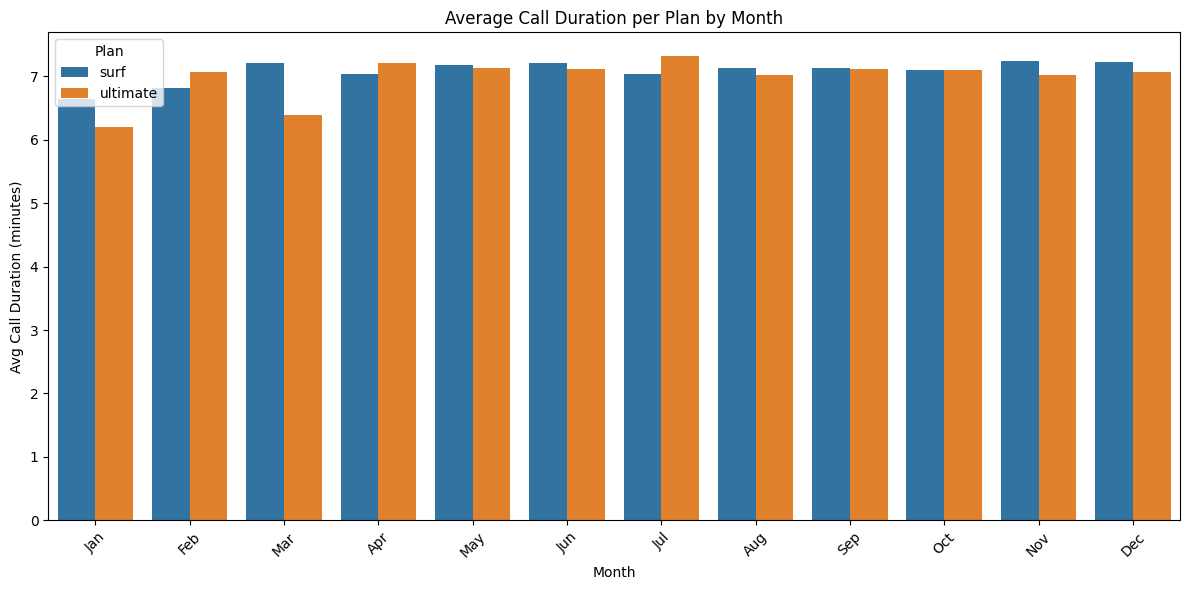

In [ ]:
# Compare average duration of calls for each plan and each distinct month. Plot a bar plot to visualize it.
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
               'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['month_name'] = pd.Categorical(df['month_name'], categories=month_order, ordered=True)

df['avg_call_duration'] = df['call_minutes'] / df['call_count']
avg_duration_by_plan = df.groupby(['month_name', 'plan'])['avg_call_duration'].mean().reset_index()
plt.figure(figsize=(12,6))
sns.barplot(data=avg_duration_by_plan, x='month_name', y='avg_call_duration', hue='plan')
plt.title('Average Call Duration per Plan by Month')
plt.ylabel('Avg Call Duration (minutes)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.legend(title='Plan')
plt.tight_layout()
plt.show()

plt.show()


Text(0, 0.5, 'Amount of Users')

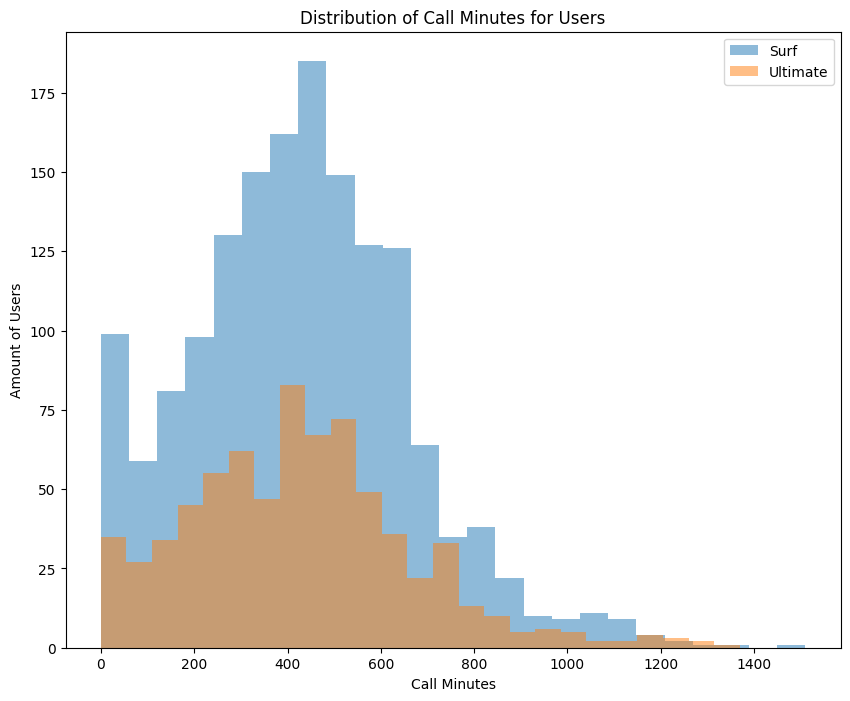

In [ ]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.
df.groupby('plan')['call_minutes'].plot.hist(alpha=0.5, legend=True, bins=25, figsize=(10,8))

plt.legend(['Surf', 'Ultimate'])
plt.title('Distribution of Call Minutes for Users')
plt.xlabel('Call Minutes')
plt.ylabel('Amount of Users')

In [ ]:
# Calculating the mean and the variance of the monthly call duration
calls_pivot = df.pivot_table(index='plan', values=['call_minutes'], aggfunc=['mean', 'std', 'var'])
print(calls_pivot)

                 mean          std           var
         call_minutes call_minutes  call_minutes
plan                                            
surf       428.749523   234.453150  54968.279461
ultimate   430.450000   240.508762  57844.464812


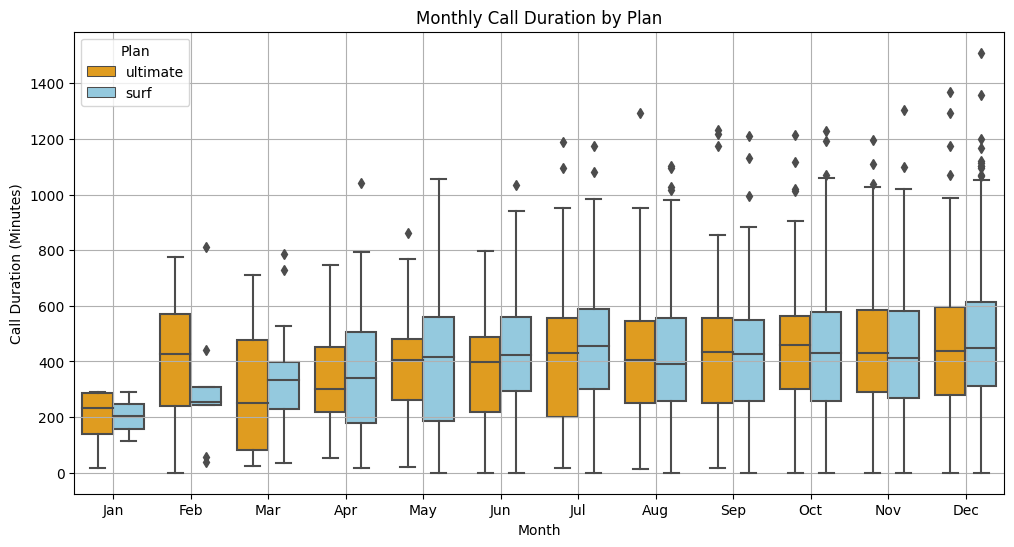

In [ ]:
# Plotting a boxplot to visualize the distribution of the monthly call duration
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
               'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['month_name'] = pd.Categorical(df['month_name'], categories=month_order, ordered=True)

palette = {'surf': 'skyblue', 'ultimate': 'orange'}
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='month_name', y='call_minutes', hue='plan', palette= palette)

plt.title('Monthly Call Duration by Plan')
plt.xlabel('Month')
plt.ylabel('Call Duration (Minutes)')
plt.legend(title='Plan')
plt.grid(True)
plt.show()

### Call Duration Conclusion:

When comparing how users behave with the Surf and Ultimate plans, both show similar trends in montly call usage. The average and median monthly call durations for both plans are usually under 500 minutes, even for Ultimate users who have a much higher limit.

What stands out to me is that Surf users have **more outliers** — especially from July to December (maybe the holidays)— with several people going well over the 500-minute limit. This may mean some Surf users are paying extra fees for extra minutes. On the other hand, Ultimate users are more consistent in their usage, and even the heaviest users don’t seem to come close to their limit.

This tells us that most users don’t actually need more than 500 minutes a month, but a small group of Surf users might benefit from switching to Ultimate to avoid overage charges. It also shows that the higher cap on the Ultimate plan isn’t really necessary for the average user.


### Messages

Text(0, 0.5, 'Amount of Users')

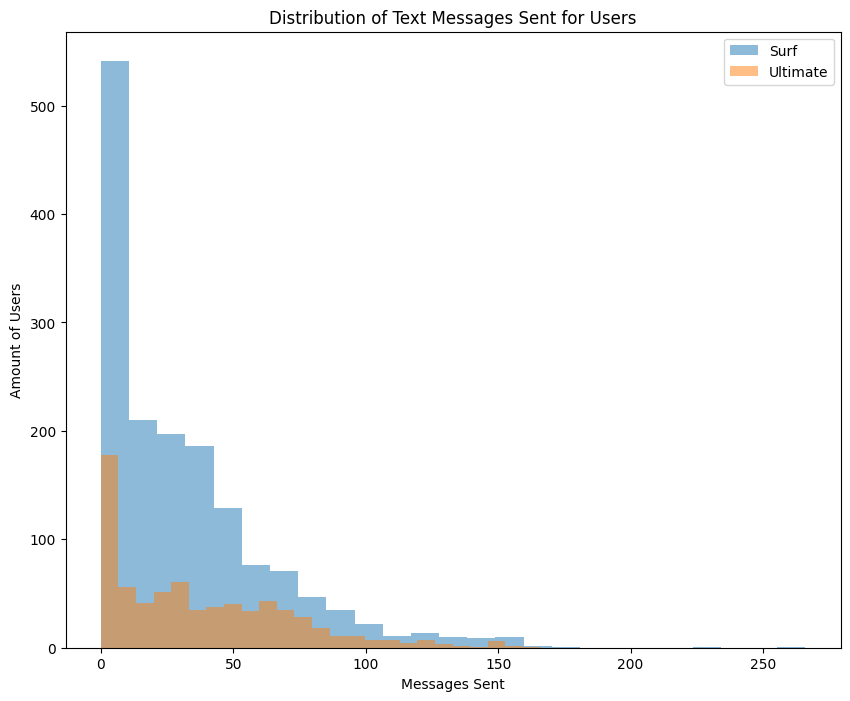

In [ ]:
# Compare the number of messages users of each plan tend to send each month
df.groupby('plan')['message_count'].plot.hist(alpha=0.5, legend=True, bins=25, figsize=(10,8))

plt.legend(['Surf', 'Ultimate'])
plt.title('Distribution of Text Messages Sent for Users')
plt.xlabel('Messages Sent')
plt.ylabel('Amount of Users')

In [ ]:
messages_pivot = df.pivot_table(index='plan', values=['message_count'], aggfunc=['mean', 'std', 'var'])
print(messages_pivot)

                  mean           std           var
         message_count message_count message_count
plan                                              
surf         31.159568     33.566717   1126.724522
ultimate     37.551389     34.767179   1208.756744


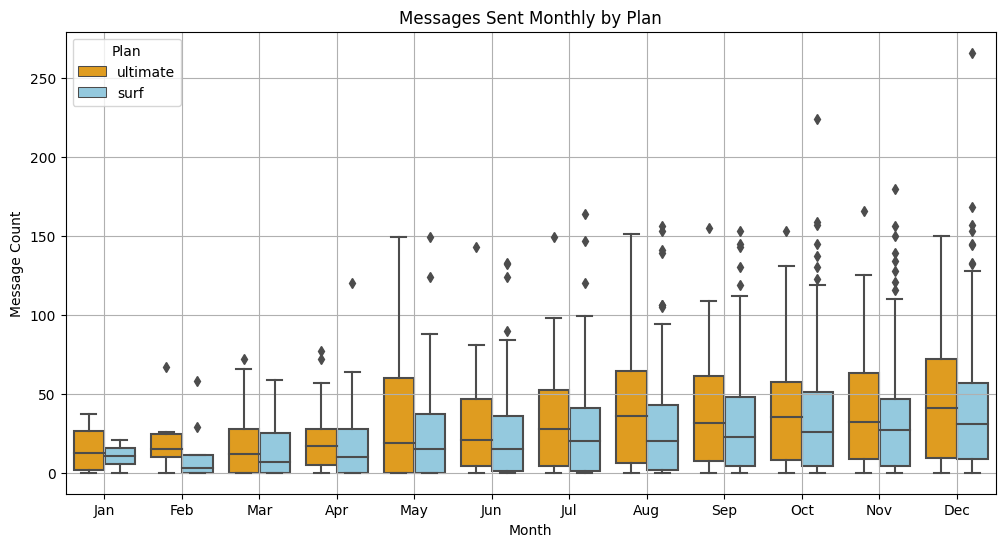

In [ ]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
               'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['month_name'] = pd.Categorical(df['month_name'], categories=month_order, ordered=True)

palette = {'surf': 'skyblue', 'ultimate': 'orange'}
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='month_name', y='message_count', hue='plan', palette= palette)

plt.title('Messages Sent Monthly by Plan')
plt.xlabel('Month')
plt.ylabel('Message Count')
plt.legend(title='Plan')
plt.grid(True)
plt.show()

### Text Messages Sent Conclusion

Users of the Ultimate plan seem to send more text messages each month compared to users of the Surf plan. However, in most months, the average and median amount of texts is below 50 for both plans.

Surf users have more outliers again — meaning a few people are going over the 50-message limit. But what really stands out to me is that **Ultimate users barely get close to their 1000-message limit**. Even the highest message counts each month are still far below that.

This shows that while Surf users might occasionally go over, **most people don’t actually text enough to need what the Ultimate plan offers**. The 1000-text limit is looking like way more than what users actually use.

### Internet

Text(0, 0.5, 'Amount of Users')

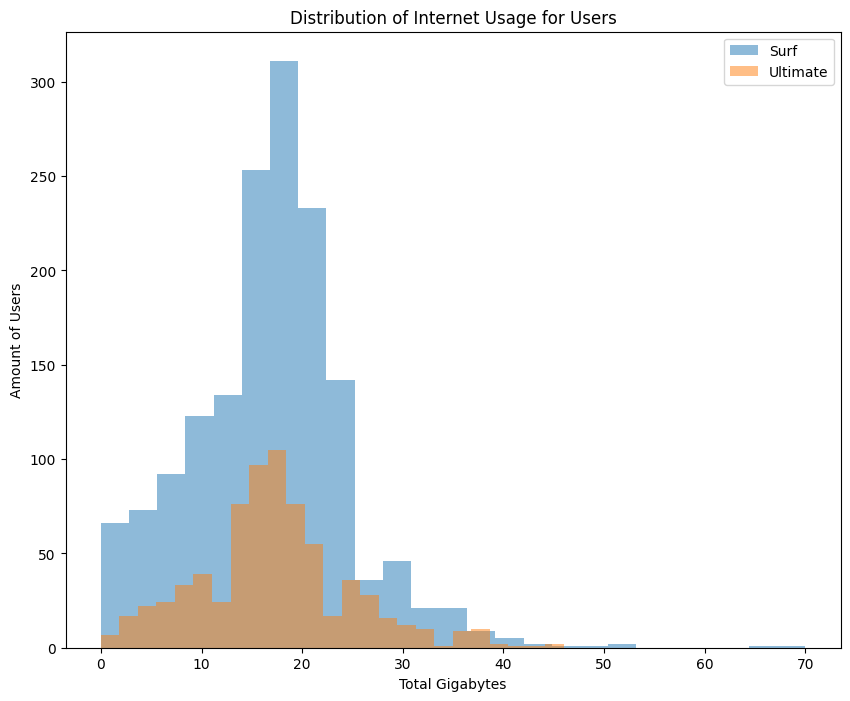

In [ ]:
# Compare the amount of internet traffic consumed by users per plan
df.groupby('plan')['total_gb'].plot.hist(alpha=0.5, legend=True, bins=25, figsize=(10,8))

plt.legend(['Surf', 'Ultimate'])
plt.title('Distribution of Internet Usage for Users')
plt.xlabel('Total Gigabytes')
plt.ylabel('Amount of Users')

In [ ]:
internet_pivot = df.pivot_table(index='plan', values=['total_gb'], aggfunc=['mean', 'std', 'var'])
print(internet_pivot)

               mean       std       var
           total_gb  total_gb  total_gb
plan                                   
surf      16.670693  7.847522  61.58360
ultimate  17.306944  7.670108  58.83055


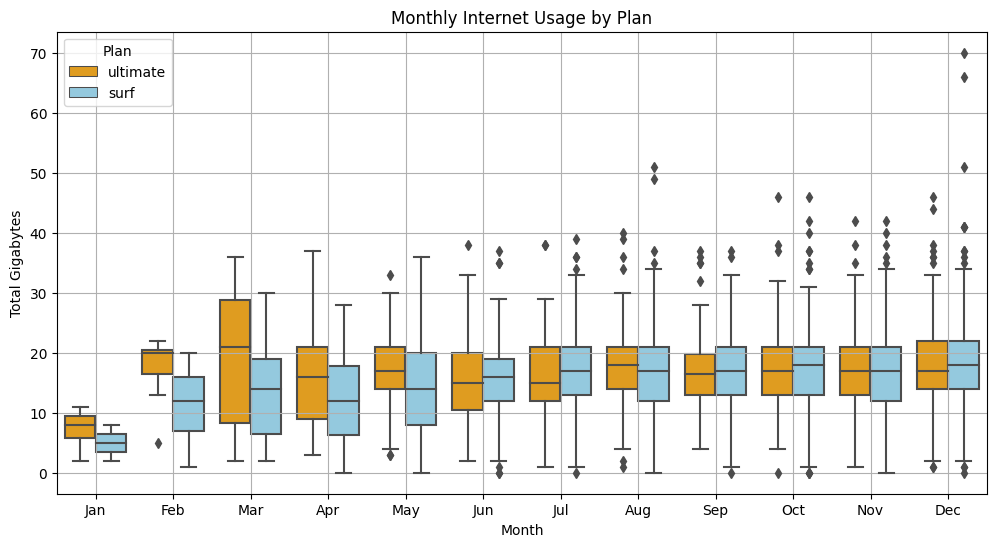

In [ ]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
               'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['month_name'] = pd.Categorical(df['month_name'], categories=month_order, ordered=True)

palette = {'surf': 'skyblue', 'ultimate': 'orange'}
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='month_name', y='total_gb', hue='plan', palette= palette)

plt.title('Monthly Internet Usage by Plan')
plt.xlabel('Month')
plt.ylabel('Total Gigabytes')
plt.legend(title='Plan')
plt.grid(True)
plt.show()

### Internet Usage Conclusion

Surf plan users are usually right around or just over their 15 GB limit, with several going over each month. This explains why Surf users might be paying overage charges. The outliers show that **some people go well beyond the limit**.

Ultimate users, on the other hand, usually stay **under their 30 GB cap**. Their usage is a bit higher than Surf overall, but not by much. Most Ultimate users don’t seem to go over their data limit often.

It’s clear that people on both plans use similar amounts of data — but Surf users are more likely to hit or exceed their cap. This likely still contributes to the extra revenue we saw from Surf.


## Revenue

Analyzing revenue between plans.

Text(0, 0.5, 'Amount of Users')

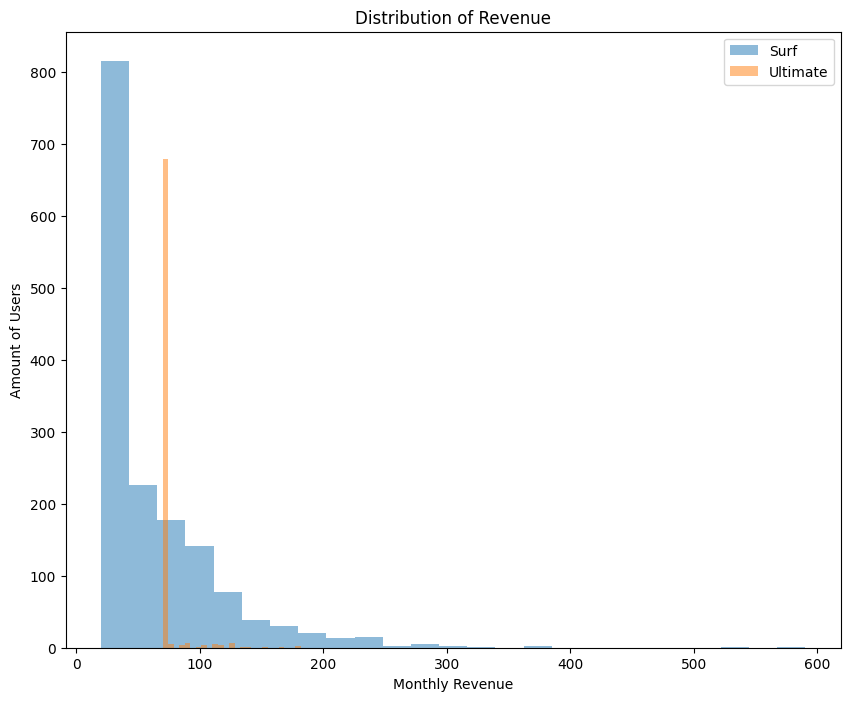

In [ ]:
df.groupby('plan')['monthly_revenue'].plot.hist(alpha=0.5, legend=True, bins=25, figsize=(10,8))

plt.legend(['Surf', 'Ultimate'])
plt.title('Distribution of Revenue')
plt.xlabel('Monthly Revenue')
plt.ylabel('Amount of Users')

In [ ]:
revenue_pivot = df.pivot_table(index='plan', values=['monthly_revenue'], aggfunc=['mean', 'std', 'var'])
print(revenue_pivot)

                    mean             std             var
         monthly_revenue monthly_revenue monthly_revenue
plan                                                    
surf           60.706408       55.388042     3067.835152
ultimate       72.313889       11.395108      129.848486


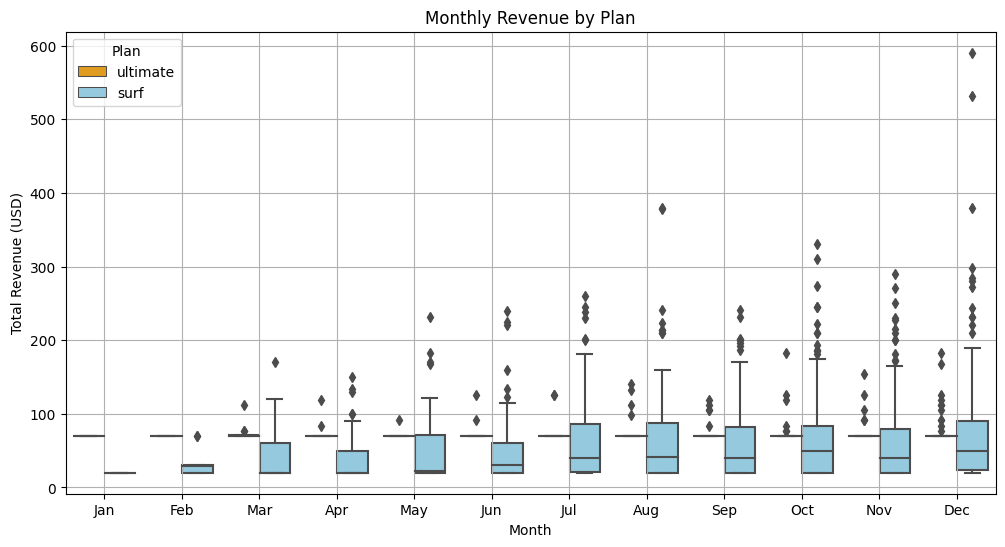

In [ ]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
               'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['month_name'] = pd.Categorical(df['month_name'], categories=month_order, ordered=True)

palette = {'surf': 'skyblue', 'ultimate': 'orange'}
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='month_name', y='monthly_revenue', hue='plan', palette= palette)

plt.title('Monthly Revenue by Plan')
plt.xlabel('Month')
plt.ylabel('Total Revenue (USD)')
plt.legend(title='Plan')
plt.grid(True)
plt.show()

### Monthly Revenue Conclusion

The Surf plan brings in more revenue overall. Even though it only costs $20 a month, many users are likely paying extra for going over their limits — especially on internet usage. The Ultimate plan is more expensive, but users probably don’t go over as often because the limits are higher and the overage charges are cheaper. 

Surf also shows more variation in revenue, even though it has a base price of `$20`  many users end up paying much more. In several months, some users are charged over `$100`, with a few reaching `$200` or higher. The Ultimate plan's revenue seems to be more stable and predictable, usually staying around the `$70` mark.

Overall, Surf generates more revenue from heavy users who exceed their limits, especially with internet usage. While Ultimate brings in steady income, Surf ends up being more profitable in many cases because of extra charges.


## Test statistical hypotheses

Testing the hypothesis that the average revenue from users of the Ultimate and Surf calling plans shows a statistically significant difference.

Null Hypothesis: No significant difference in average revenue between plans.

Alternative Hypothesis: There is a significant difference in average revenue between plans.

Testing is done via a t-test with an alpha of 5%.

In [ ]:
# Test the hypotheses
surf_revenue = df[df['plan']=='surf']['monthly_revenue']
ultimate_revenue = df[df['plan']=='ultimate']['monthly_revenue']

alpha = 0.05
results = st.ttest_ind(surf_revenue, ultimate_revenue, equal_var=False)
print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print('We reject the null hypothesis.')
else:
    print("We can't reject the null hypothesis.")

p-value:  3.1703905481135734e-15
We reject the null hypothesis.


Testing the hypothesis that the average revenue from users in the NY-NJ area is different from that of the users from the other regions.

Null Hypothesis: No significant difference between revenue from user in the NY-NJ area and other regions.

Alternative Hypothesis: There is a significant difference between revenue from user in the NY-NJ area and other regions.

In [ ]:
# Test the hypotheses
ny_nj_users = df[df['state'].str.contains('NY-NJ', na=False)]['monthly_revenue']
other_regions = df[~df.index.isin(ny_nj_users.index)]['monthly_revenue']

alpha = 0.05
results = st.ttest_ind(ny_nj_users, other_regions, equal_var=False)
print('pvalue: ', results.pvalue)

if results.pvalue < alpha:
    print('We reject the null hypothesis.')
else:
    print("We can't reject the null hypothesis.")

pvalue:  0.0335256158853001
We reject the null hypothesis.


## General conclusion
The goal of this analysis was to figure out which calling plan — Surf or Ultimate — brings in more revenue and how users behave on each one. I looked at call minutes, text messages, and internet usage to compare the two plans.

When analyzing behavior:

- **Call and text usage** were pretty similar across both plans. Most people didn’t go over their limits, except for a few Surf users who had higher usage and likely paid overage fees.
- **Internet usage** was the main driver of extra costs. Many Surf users went over their 15 GB limit, while most Ultimate users stayed within their 30 GB cap.

When looking at revenue:

- The **Surf plan generated more revenue**, mostly because users were getting charged extra — especially for going over on data limits.
- The **Ultimate plan had more stable costs**, but didn’t bring in as much extra money since the overage rates are cheaper and the limits are higher.

For the hypothesis tests:

- I found a **statistically significant difference** in average revenue between the two plans — so we can say with confidence that one plan earns more than the other.
-  I also found that there’s a **significant difference in revenue between NY-NJ users and users from other regions** — meaning location does have an impact on how much users spend.

Overall, even though Ultimate has higher limits, Surf users tend to go over their limits more often — especially with internet — which causes them to bring in more revenue for the company.